# Ungraded Lab: Feature Engineering with Images

In this optional notebook, you will be looking at how to prepare features with an image dataset, particularly [CIFAR-10](https://www.tensorflow.org/datasets/catalog/cifar10). You will mostly go through the same steps but you will need to add parser functions in your transform module to successfully read and convert the data. As with the previous notebooks, we will just go briefly over the early stages of the pipeline so you can focus on the Transform component.

Let's begin!

In [ ]:
!pip install tfx
!pip install apache-beam==2.51.0

## Imports

In [2]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
from tfx.components.transform.component import Transform

from google.protobuf.json_format import MessageToDict

print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.13.1
TFX version: 1.14.0


## Set up pipeline paths

In [3]:
# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Data files directory
_data_root = './data/cifar10'

# Path to the training data
_data_filepath = os.path.join(_data_root, 'train.tfrecord')

## Download example data

We will download the training split of the CIFAR-10 dataset and save it to the `_data_filepath`. Take note that this is already in TFRecord format so we won't need to convert it when we use `ExampleGen` later.

In [4]:
# Create data folder for the images
!mkdir -p {_data_root}

# URL of the hosted dataset
DATA_PATH = 'https://raw.githubusercontent.com/tensorflow/tfx/v0.21.4/tfx/examples/cifar10/data/train.tfrecord'

# Download the dataset and save locally
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('./data/cifar10/train.tfrecord', <http.client.HTTPMessage at 0x789268c7b0a0>)

## Create the InteractiveContext

In [5]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root)

## Run TFX components interactively



### ExampleGen

As mentioned earlier, the dataset is already in TFRecord format so, unlike the previous TFX labs, there is no need to convert it when we ingest the data. You can simply import it with [ImportExampleGen](https://www.tensorflow.org/tfx/api_docs/python/tfx/components/ImportExampleGen) and here is the syntax and modules for that.

In [6]:
# Module needed to import TFRecord files
from tfx.components import ImportExampleGen

# Ingest the data through ExampleGen
example_gen = ImportExampleGen(input_base=_data_root)

# Run the component
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

As usual, this component produces two artifacts, training examples and evaluation examples:

In [7]:
# Print split names and URI
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] ./pipeline/ImportExampleGen/examples/1


You can also take a look at the first three training examples ingested by using the `tf.io.parse_single_example()` method from the [tf.io](https://www.tensorflow.org/api_docs/python/tf/io) module. See how it is setup in the cell below.

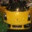

'Class ID: 1'


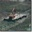

'Class ID: 8'


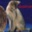

'Class ID: 3'


In [9]:
import IPython.display as display

# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Description per example
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

# Image parser function
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

# Map the parser to the dataset
parsed_image_dataset = dataset.map(_parse_image_function)

# Display the first three images
for features in parsed_image_dataset.take(3):
    image_raw = features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    pprint.pprint('Class ID: {}'.format(features['label'].numpy()))

### StatisticsGen

Next, you will generate the statistics so you can infer a schema in the next step. You can also look at the visualization of the statistics. As you might expect with CIFAR-10, there is a column for the image and another column for the numeric label.

In [10]:
# Run StatisticsGen
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [11]:
# Visualize the results
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

Here, you pass in the statistics to generate the Schema. For the version of TFX you are using, you will have to explicitly set `infer_feature_shape=True` so the downstream TFX components (e.g. Transform) will parse input as a `Tensor` and not `SparseTensor`. If not set, you will have compatibility issues later when you run the transform.

In [12]:
# Run SchemaGen
schema_gen = SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [13]:
# Visualize the results
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image_raw',BYTES,required,,-
'label',INT,required,,-


### ExampleValidator

`ExampleValidator` is not required but you can still run it just to make sure that there are no anomalies.

In [14]:
# Run ExampleValidator
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [15]:
# Visualize the results. There should be no anomalies.
context.show(example_validator.outputs['anomalies'])

### Transform

To successfully transform the raw image, you need to parse the current bytes format and convert it to a tensor. For that, you can use the [tf.image.decode_image()](https://www.tensorflow.org/api_docs/python/tf/io/decode_image) function. The transform module below utilizes this and converts the image to a `(32,32,3)` shaped float tensor. It also scales the pixels and converts the labels to one-hot tensors. The output features should then be ready to pass on to a model that accepts this format.

In [16]:
_transform_module_file = 'cifar10_transform.py'

In [17]:
%%writefile {_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft

# Keys
_LABEL_KEY = 'label'
_IMAGE_KEY = 'image_raw'


def _transformed_name(key):
    return key + '_xf'

def _image_parser(image_str):
    '''converts the images to a float tensor'''
    image = tf.image.decode_image(image_str, channels=3)
    image = tf.reshape(image, (32, 32, 3))
    image = tf.cast(image, tf.float32)
    return image


def _label_parser(label_id):
    '''one hot encodes the labels'''
    label = tf.one_hot(label_id, 10)
    return label


def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """

    # Convert the raw image and labels to a float array and
    # one-hot encoded labels, respectively.
    with tf.device("/cpu:0"):
        outputs = {
            _transformed_name(_IMAGE_KEY):
                tf.map_fn(
                    _image_parser,
                    tf.squeeze(inputs[_IMAGE_KEY], axis=1),
                    dtype=tf.float32),
            _transformed_name(_LABEL_KEY):
                tf.map_fn(
                    _label_parser,
                    tf.squeeze(inputs[_LABEL_KEY], axis=1),
                    dtype=tf.float32)
        }

    # scale the pixels from 0 to 1
    outputs[_transformed_name(_IMAGE_KEY)] = tft.scale_to_0_1(outputs[_transformed_name(_IMAGE_KEY)])

    return outputs

Writing cifar10_transform.py


Now, we pass in this feature engineering code to the `Transform` component and run it to transform your data.

In [18]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Setup the Transform component
transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

### Preview the results

Now that the Transform component is finished, you can preview how the transformed images and labels look like. You can use the same sequence and helper function from previous labs.

In [20]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [21]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''

    # initialize an empty list
    records = []

    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):

        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()

        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()

        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)

        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))

        # append to the records list
        records.append(example_dict)

    return records

You should see from the output of the cell below that the transformed raw image (i.e. `image_raw_xf`) now has a float array that is scaled from 0 to 1. Similarly, you'll see that the transformed label (i.e. `label_xf`) is now one-hot encoded.

In [22]:
# Get 1 record from the dataset
sample_records = get_records(dataset, 1)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'image_raw_xf': {'floatList': {'value': [0.16470589,
                                                                    0.09019608,
                                                                    0.0627451,
                                                                    0.2627451,
                                                                    0.2,
                                                                    0.14901961,
                                                                    0.28627452,
                                                                    0.22352941,
                                                                    0.16078432,
                                                                    0.29803923,
                                                                    0.2509804,
                                                                    0.16470589,
                                                  

### Wrap Up

This notebook demonstrates how to do feature engineering with image datasets as opposed to simple tabular data. This should come in handy in your computer vision projects and you can also try replicating this process with other image datasets from [TFDS](https://www.tensorflow.org/datasets/catalog/overview#image_classification).